<p> The dataset contains more than 800,000 consumer loans issued from 2007 to 2015 by Lending Club: a large US peer-to-peer lending company <br>Data can be found here: <a href = "https://www.kaggle.com/wendykan/lending-club-loan-data/version/1">Link</a> </p>

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [2]:
df = pd.read_csv("loan_data_2007_2014.csv", low_memory = False)

<h3> Continuous variables </h3>

In [3]:
#pre-processing strings to int

df['emp_length_int'] = df['emp_length'].str.replace(' year', '')
df['emp_length_int'] = df['emp_length_int'].str.replace('s', '')
df['emp_length_int'] = df['emp_length_int'].str.replace('+', '')
df['emp_length_int'] = df['emp_length_int'].str.replace('< 1', '0')

df['emp_length_int'] = pd.to_numeric(df['emp_length_int'])

C:\Users\ngchi\AppData\Local\Temp\ipykernel_4052\3208970195.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['emp_length_int'] = df['emp_length_int'].str.replace('+', '')


In [4]:
#pre-processing strings to int

df['term_int'] = df['term'].str.replace(' months', '')
df['term_int'] = df['term_int'].str.strip()

df['term_int'] = pd.to_numeric(df['term_int'])

In [5]:
df = df.dropna(subset = ['earliest_cr_line'])

In [6]:
#reading in cr line date. When we convert to datetime, those with 60s get misinterpreted as 2060s instead of 1960s. 
#anything with the %y year below 69 will be attributed a century of 2000, and 69 upwards get 1900

list_a = list()

for i in df['earliest_cr_line']:
    
    if (23 <= float(i[-2:]) < 69):
        
        i = list(i)
        i.insert(4, '1')
        i.insert(5, '9')
        
        i = "".join(i)       #convert list back to string
    
    elif (0 <= float(i[-2:]) < 23): 
        
        i = list(i)
        i.insert(4, '2')
        i.insert(5, '0')
        
        i = "".join(i)
        
    else:
        
        i = list(i)
        i.insert(4, '1')
        i.insert(5, '9')
        
        i = "".join(i)   
        
    list_a.append(i)

In [7]:
df['earliest_cr_line'] = list_a

In [8]:
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format = '%b-%Y')
df['months_since_earliest_cr_line'] = round((pd.to_datetime('2017-12-01') - df['earliest_cr_line_date']) / np.timedelta64(1, 'M'))

In [9]:
df['issue_d_date'] = pd.to_datetime(df['issue_d'], format = '%b-%y')
df['mths_since_issue_d'] = round((pd.to_datetime('2017-12-01') - df['issue_d_date']) / np.timedelta64(1, 'M'))

<h3> Discrete variables </h3>

In [10]:
df_dummies = [pd.get_dummies(df['grade'], prefix = 'grade', prefix_sep = " : "), 
              pd.get_dummies(df['sub_grade'], prefix = 'sub_grade', prefix_sep = " : "), 
              pd.get_dummies(df['home_ownership'], prefix = 'home_ownership', prefix_sep = " : "),
              pd.get_dummies(df['loan_status'], prefix = 'loan_status', prefix_sep = " : "),
              pd.get_dummies(df['purpose'], prefix = 'purpose', prefix_sep = " : "),
              pd.get_dummies(df['addr_state'], prefix = 'addr_state', prefix_sep = " : "),
              pd.get_dummies(df['initial_list_status'], prefix = 'initial_list_status', prefix_sep = " : ")]

In [11]:
df_dummies = pd.concat(df_dummies, axis = 1)

In [12]:
df = pd.concat([df, df_dummies], axis = 1)

<h3> Missing treatment </h3>

In [13]:
df.isnull().sum()

id                         0
loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
                          ..
addr_state : WI            0
addr_state : WV            0
addr_state : WY            0
initial_list_status : f    0
initial_list_status : w    0
Length: 176, dtype: int64

In [14]:
df['total_rev_hi_lim'].fillna(df['funded_amnt'], inplace=True)
df['annual_inc'].fillna(df['annual_inc'].mean(), inplace=True)
df['acc_now_delinq'].fillna(0, inplace=True)
df['total_acc'].fillna(0, inplace=True)
df['pub_rec'].fillna(0, inplace=True)
df['open_acc'].fillna(0, inplace=True)
df['inq_last_6mths'].fillna(0, inplace=True)
df['delinq_2yrs'].fillna(0, inplace=True)
df['emp_length_int'].fillna(0, inplace=True)

<h3> Dependent variables </h3>

In [15]:
# 1 means defaulted, 0 means non-default

df['good_bad'] = np.where(df['loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',  'Does not meet the credit policy. Status:Charged Off']), 1 , 0)
df[['good_bad', 'loan_status']]

,good_bad,loan_status
0,0,Fully Paid
1,1,Charged Off
2,0,Fully Paid
3,0,Fully Paid
4,0,Current
...,...,...
466280,0,Current
466281,1,Charged Off
466282,0,Current
466283,0,Fully Paid


In [16]:
df.columns = df.columns.str.replace(" ", "")

<h3> WOE for Binning Categorical Variables </h3>

<h4> For 'Grade' </h4>

In [17]:
def woe_discrete(categorical_var):
    
    WoE_results = pd.DataFrame()

    WoE_results[categorical_var] = df[categorical_var]
    WoE_results['Good_Bad'] = df['good_bad']

    Count = WoE_results.groupby([categorical_var]).count().reset_index()
    Mean = WoE_results.groupby([categorical_var]).mean().reset_index()

    df1 = pd.concat([Count, Mean], axis = 1)
    df1 = df1.iloc[:,[0,1,3]]

    df1.columns = [categorical_var, 'n_obs', 'prop_bad']

    df1['prop_good'] = 1 - df1['prop_bad']

    df1['n_bad'] = df1['prop_bad'] * df1['n_obs']
    df1['n_good'] = df1['prop_good'] * df1['n_obs']

    df1['prop_n_bad'] = df1['n_bad'] / df1['n_bad'].sum()
    df1['prop_n_good'] = df1['n_good'] / df1['n_good'].sum()

    df1['WoE'] = np.log(df1['prop_n_good'] / df1['prop_n_bad'])

    df1['%Good - %Bad'] = df1['prop_n_good'] - df1['prop_n_bad'] 

    df1['IV'] = df1['WoE'] * df1['%Good - %Bad']

    df1.IV = df1.IV.sum()
    
    df1.sort_values(by='WoE', inplace = True)

    return df1

woe_discrete('grade')

,grade,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
6,G,3322,0.278146,0.721854,924.0,2398.0,0.018130,0.005774,-1.144162,-0.012356,0.290812
5,F,13229,0.241288,0.758712,3192.0,10037.0,0.062631,0.024169,-0.952210,-0.038463,0.290812
4,E,35756,0.194765,0.805235,6964.0,28792.0,0.136643,0.069330,-0.678497,-0.067313,0.290812
3,D,76887,0.154083,0.845917,11847.0,65040.0,0.232454,0.156613,-0.394913,-0.075841,0.290812
2,C,125287,0.114808,0.885192,14384.0,110903.0,0.282233,0.267049,-0.055301,-0.015184,0.290812
1,B,136919,0.078572,0.921428,10758.0,126161.0,0.211086,0.303789,0.364069,0.092703,0.290812
0,A,74856,0.038688,0.961312,2896.0,71960.0,0.056823,0.173276,1.114940,0.116453,0.290812


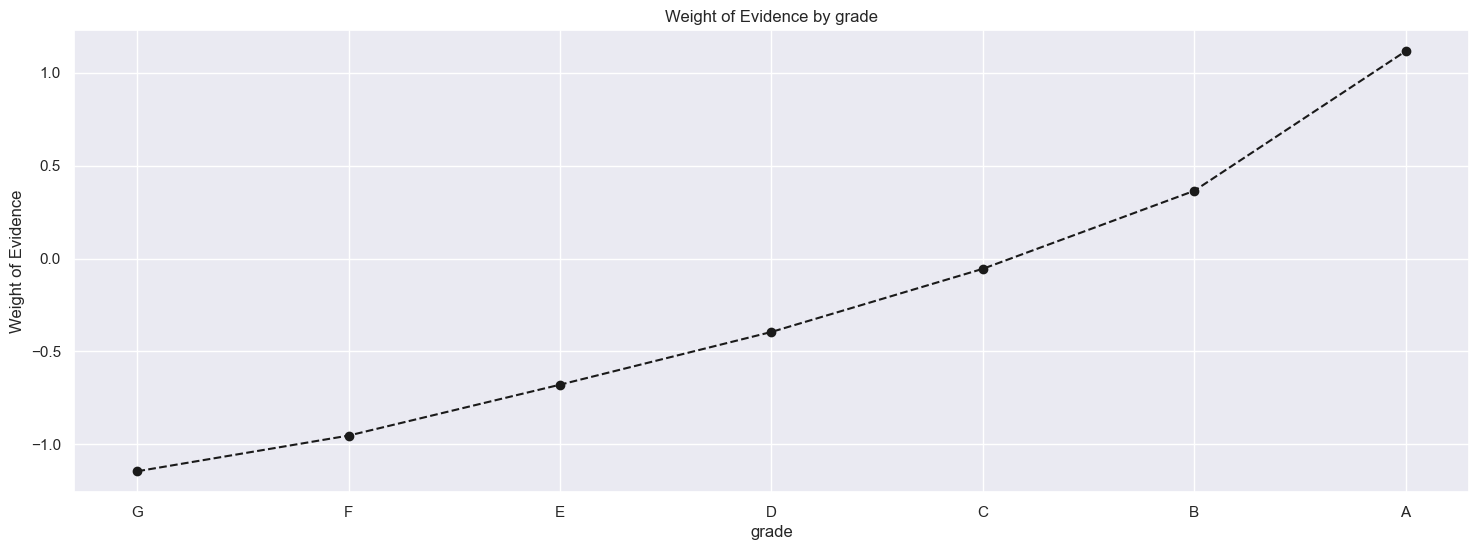

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()                                #make sns the default style compared to matplotlib

def plot_by_woe(df, rotation_of_x_axis_labels = 0):
    x = np.array(df.iloc[:, 0].apply(str))               #matplotlib works better with numpy and scipy
    y = df['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)
    
plot_by_woe(woe_discrete('grade'))
#looks ok

<h4> For 'Home Ownership' </h4>

In [19]:
woe_discrete('home_ownership')

,home_ownership,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
3,OTHER,182,0.208791,0.791209,38.0,144.0,0.000746,0.000347,-0.765613,-0.000399,inf
2,NONE,46,0.173913,0.826087,8.0,38.0,0.000157,0.000092,-0.539696,-0.000065,inf
5,RENT,188456,0.126104,0.873896,23765.0,164691.0,0.466300,0.396568,-0.161983,-0.069733,inf
4,OWN,41703,0.108266,0.891734,4515.0,37188.0,0.088590,0.089547,0.010741,0.000957,inf
1,MORTGAGE,235868,0.095982,0.904018,22639.0,213229.0,0.444207,0.513445,0.144852,0.069238,inf
0,ANY,1,0.000000,1.000000,0.0,1.0,0.000000,0.000002,inf,0.000002,inf


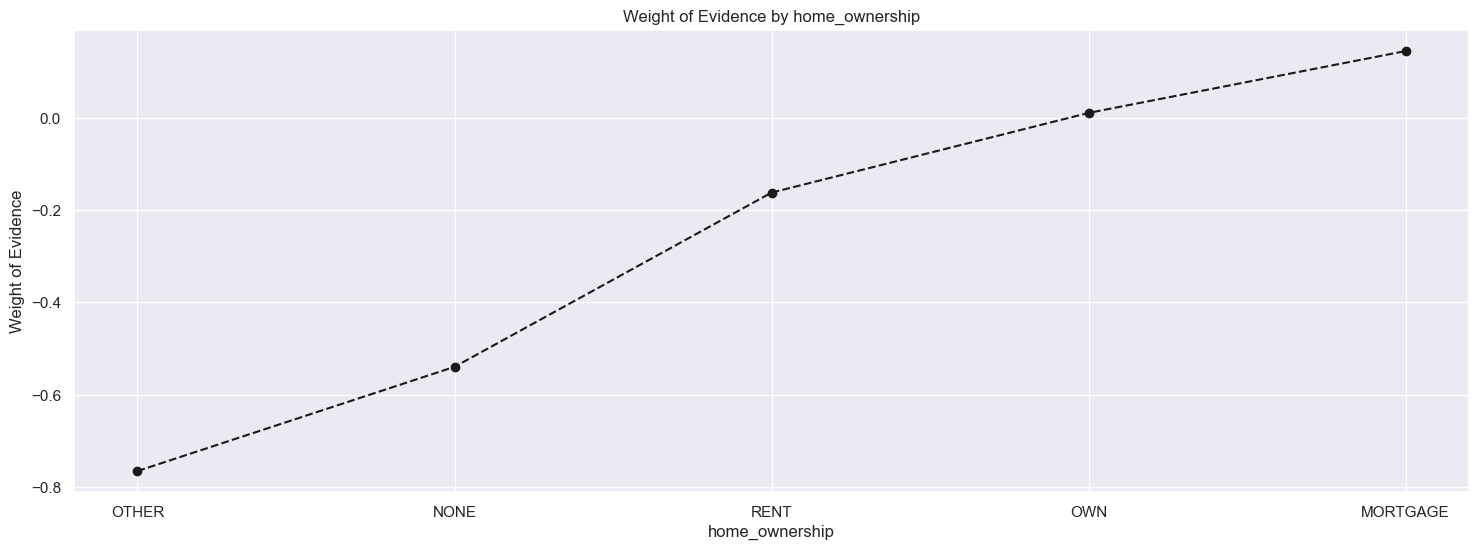

In [20]:
plot_by_woe(woe_discrete('home_ownership'))
#looks ok but OTHER, NONE and ANY have very low number of observations. Will group with RENT since closest to its WoE. 

In [21]:
df['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df['home_ownership:RENT'], df['home_ownership:OTHER'],
                                                            df['home_ownership:NONE'], df['home_ownership:ANY']])

<h4> For 'Address State' </h4>

In [22]:
# woe_discrete('addr_state')

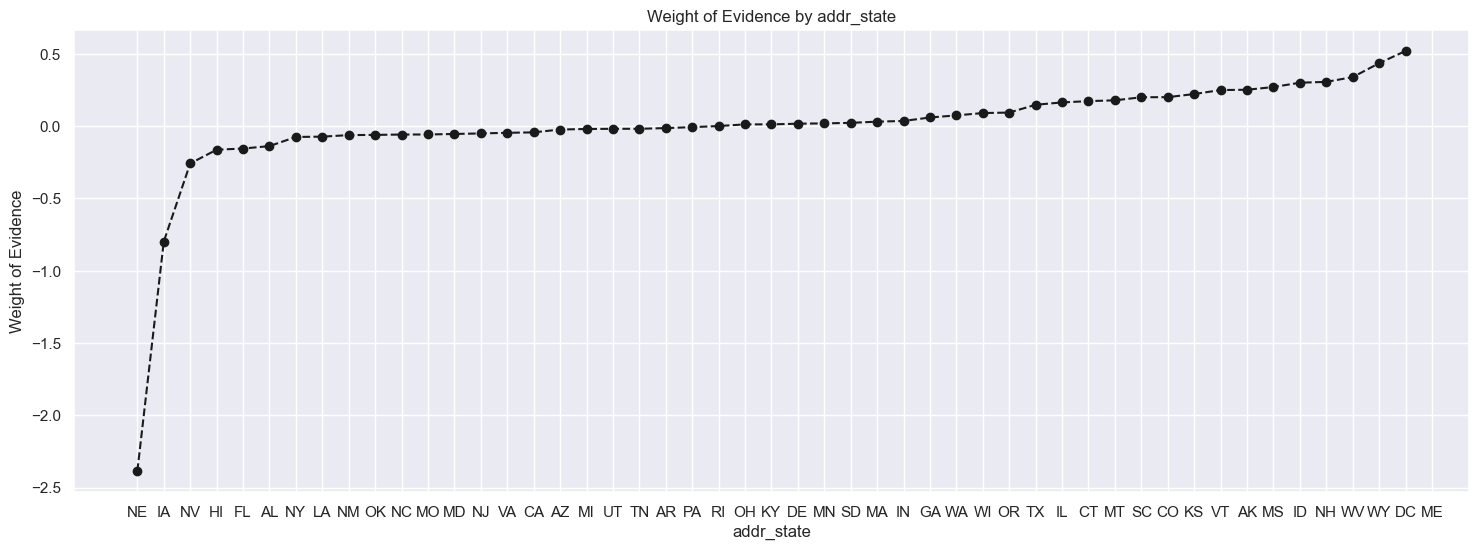

In [23]:
plot_by_woe(woe_discrete('addr_state'))

In [24]:
df['addr_state:NE_IA_NV_FL_HI_AL'] = sum([df['addr_state:NE'],
                                          df['addr_state:IA'], df['addr_state:NV'],
                                          df['addr_state:FL'], df['addr_state:HI'],
                                          df['addr_state:AL']])

df['addr_state:NM_VA'] = sum([df['addr_state:NM'], df['addr_state:VA']])

df['addr_state:OK_TN_MO_LA_MD_NC'] = sum([df['addr_state:OK'], df['addr_state:TN'],
                                              df['addr_state:MO'], df['addr_state:LA'],
                                              df['addr_state:MD'], df['addr_state:NC']])

df['addr_state:UT_KY_AZ_NJ'] = sum([df['addr_state:UT'], df['addr_state:KY'],
                                              df['addr_state:AZ'], df['addr_state:NJ']])

df['addr_state:AR_MI_PA_OH_MN'] = sum([df['addr_state:AR'], df['addr_state:MI'],
                                              df['addr_state:PA'], df['addr_state:OH'],
                                              df['addr_state:MN']])

df['addr_state:RI_MA_DE_SD_IN'] = sum([df['addr_state:RI'], df['addr_state:MA'],
                                              df['addr_state:DE'], df['addr_state:SD'],
                                              df['addr_state:IN']])

df['addr_state:GA_WA_OR'] = sum([df['addr_state:GA'], df['addr_state:WA'],
                                              df['addr_state:OR']])

df['addr_state:WI_MT'] = sum([df['addr_state:WI'], df['addr_state:MT']])

df['addr_state:IL_CT'] = sum([df['addr_state:IL'], df['addr_state:CT']])

df['addr_state:KS_SC_CO_VT_AK_MS'] = sum([df['addr_state:KS'], df['addr_state:SC'],
                                              df['addr_state:CO'], df['addr_state:VT'],
                                              df['addr_state:AK'], df['addr_state:MS']])

df['addr_state:WV_NH_WY_DC_ME_ID'] = sum([df['addr_state:WV'], df['addr_state:NH'],
                                              df['addr_state:WY'], df['addr_state:DC'],
                                              df['addr_state:ME'], df['addr_state:ID']])

<h3> Preprocess continuous variable </h3>

<h4> Term_Int </h4>

In [25]:
def woe_continuous(continuous_var):
    
    WoE_results = pd.DataFrame()

    WoE_results[continuous_var] = df[continuous_var]
    WoE_results['Good_Bad'] = df['good_bad']

    Count = WoE_results.groupby([continuous_var]).count().reset_index()
    Mean = WoE_results.groupby([continuous_var]).mean().reset_index()

    df1 = pd.concat([Count, Mean], axis = 1)
    df1 = df1.iloc[:,[0,1,3]]

    df1.columns = [continuous_var, 'n_obs', 'prop_bad']

    df1['prop_good'] = 1 - df1['prop_bad']

    df1['n_bad'] = df1['prop_bad'] * df1['n_obs']
    df1['n_good'] = df1['prop_good'] * df1['n_obs']

    df1['prop_n_bad'] = df1['n_bad'] / df1['n_bad'].sum()
    df1['prop_n_good'] = df1['n_good'] / df1['n_good'].sum()

    df1['WoE'] = np.log(df1['prop_n_good'] / df1['prop_n_bad'])

    df1['%Good - %Bad'] = df1['prop_n_good'] - df1['prop_n_bad'] 

    df1['IV'] = df1['WoE'] * df1['%Good - %Bad']

    df1.IV = df1.IV.sum()

    return df1

woe_continuous('term_int')

,term_int,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,36,337924,0.097084,0.902916,32807.0,305117.0,0.643716,0.734707,0.132213,0.09099,0.038862
1,60,128332,0.141492,0.858508,18158.0,110174.0,0.356284,0.265293,-0.294891,-0.09099,0.038862


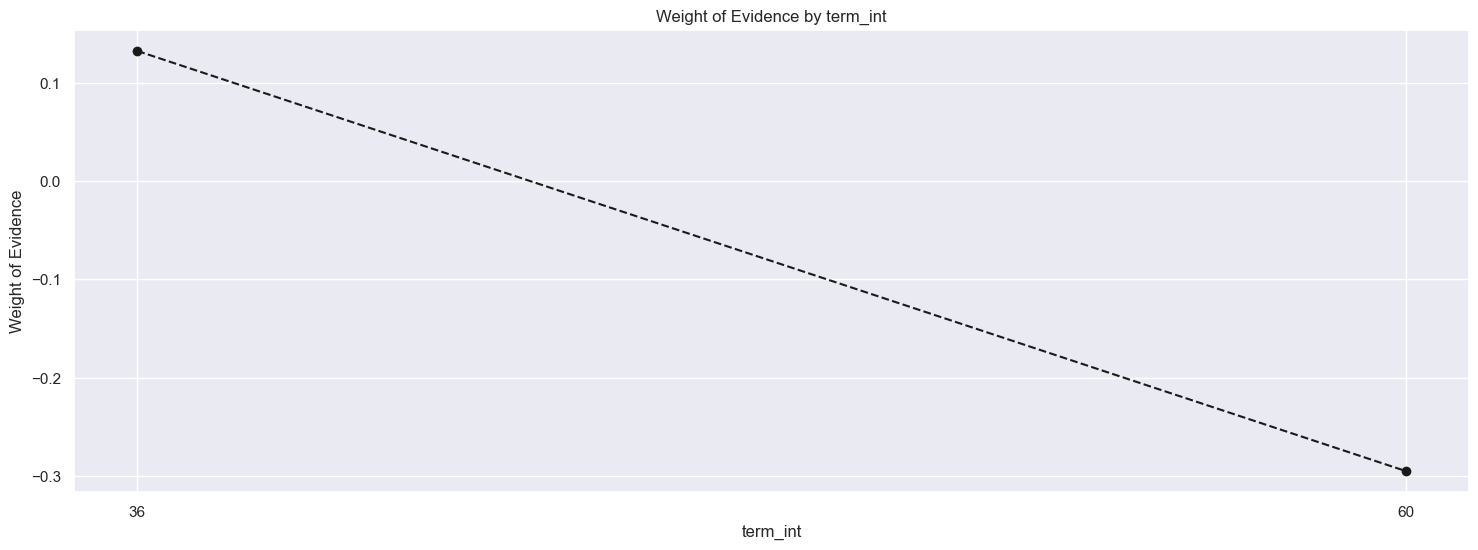

In [26]:
plot_by_woe(woe_continuous('term_int'))

In [27]:
df['term:36'] = np.where(df['term_int'] == 36, 1, 0)
df['term:60'] = np.where(df['term_int'] == 60, 1, 0)

<h4> Employment Length </h4>

In [28]:
woe_continuous('emp_length_int')

,emp_length_int,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,0.0,57255,0.124007,0.875993,7100.0,50155.0,0.139311,0.120771,-0.142817,-0.018541,0.006617
1,1.0,29619,0.111854,0.888146,3313.0,26306.0,0.065005,0.063344,-0.025897,-0.001662,0.006617
2,2.0,41372,0.109760,0.890240,4541.0,36831.0,0.089100,0.088687,-0.004648,-0.000413,0.006617
3,3.0,36594,0.109499,0.890501,4007.0,32587.0,0.078623,0.078468,-0.001970,-0.000155,0.006617
4,4.0,28023,0.109589,0.890411,3071.0,24952.0,0.060257,0.060083,-0.002890,-0.000174,0.006617
5,5.0,30774,0.114967,0.885033,3538.0,27236.0,0.069420,0.065583,-0.056862,-0.003837,0.006617
6,6.0,26111,0.117115,0.882885,3058.0,23053.0,0.060002,0.055510,-0.077806,-0.004491,0.006617
7,7.0,26180,0.111345,0.888655,2915.0,23265.0,0.057196,0.056021,-0.020760,-0.001175,0.006617
8,8.0,22395,0.110069,0.889931,2465.0,19930.0,0.048367,0.047990,-0.007806,-0.000376,0.006617
9,9.0,17887,0.112093,0.887907,2005.0,15882.0,0.039341,0.038243,-0.028298,-0.001098,0.006617


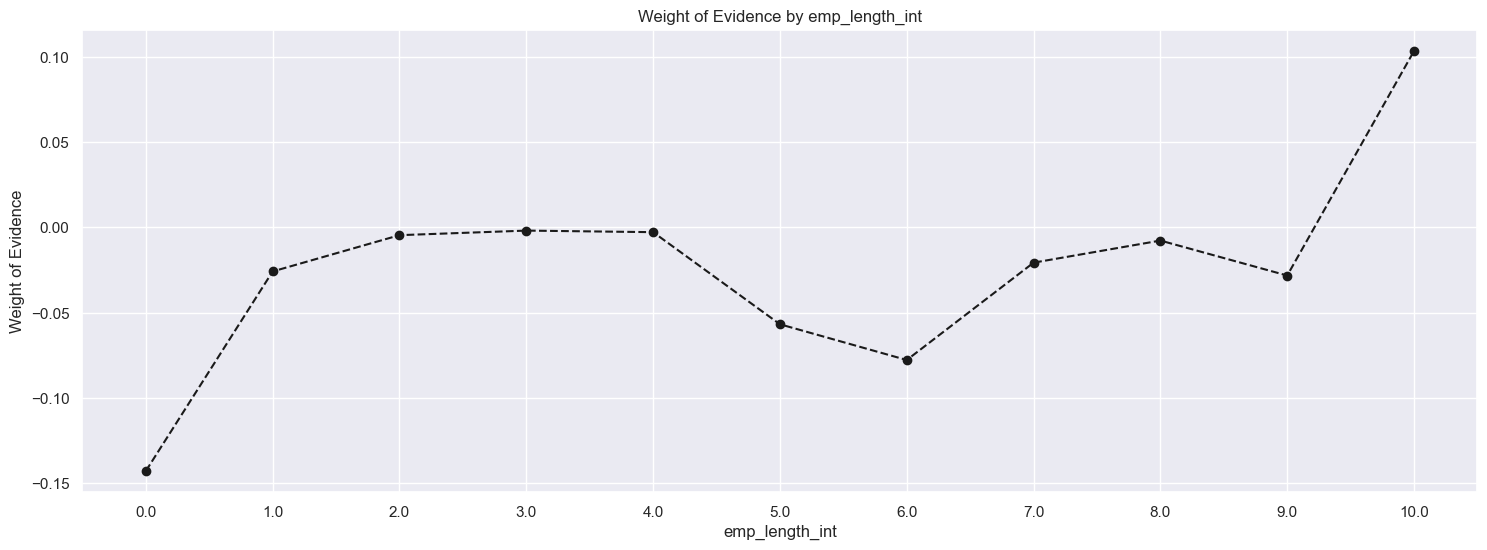

In [29]:
plot_by_woe(woe_continuous('emp_length_int'))

In [30]:
df['emp_length:0'] = np.where(df['emp_length_int'].isin([0]), 1 ,0)
df['emp_length:1'] = np.where(df['emp_length_int'].isin([1]), 1 ,0)
df['emp_length:2-4'] = np.where(df['emp_length_int'].isin([2,3,4]), 1 ,0)
df['emp_length:5-6'] = np.where(df['emp_length_int'].isin([5,6]), 1 ,0)
df['emp_length:7-9'] = np.where(df['emp_length_int'].isin([7,8,9]), 1 ,0)
df['emp_length:10'] = np.where(df['emp_length_int'].isin([10]), 1 ,0)

<h4> Mths_Since_Issue </h4>

In [31]:
df['mths_since_issue_d_factor'] = pd.qcut(df['mths_since_issue_d'], 10)

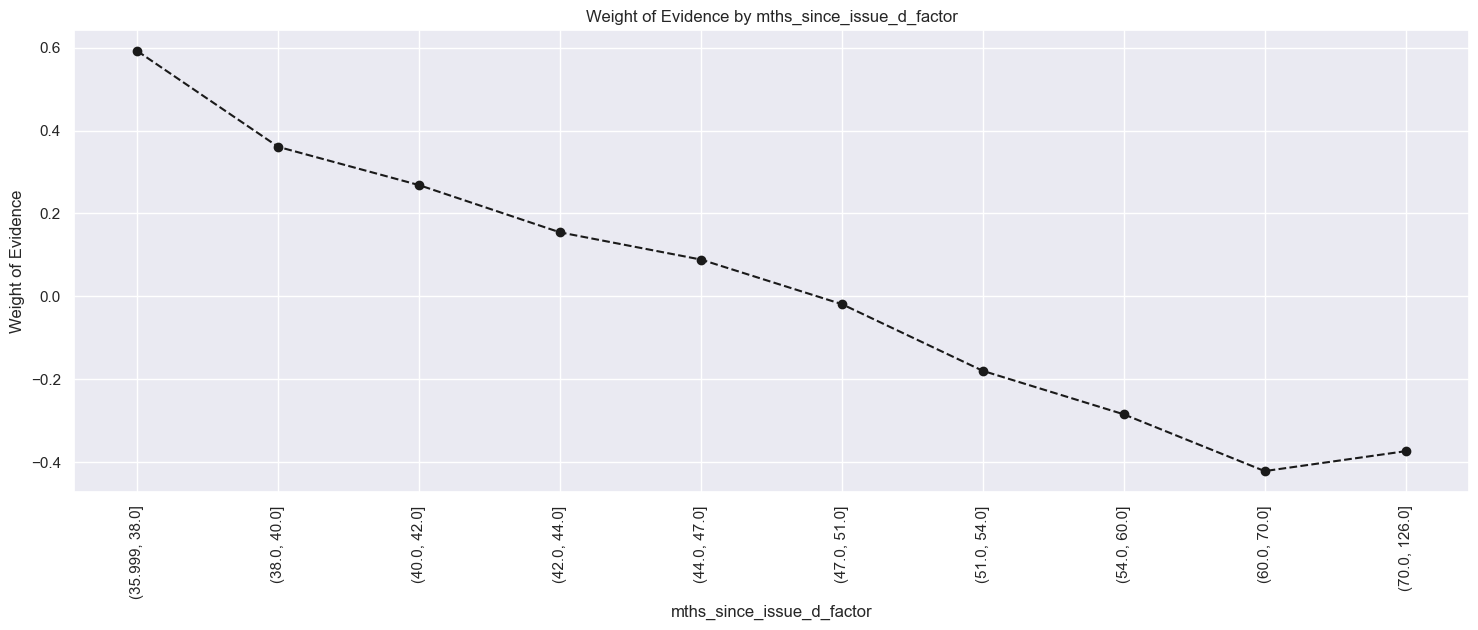

In [32]:
plot_by_woe(woe_continuous('mths_since_issue_d_factor'), 90)

In [33]:
# We create the following categories:
# < 38, 38 - 39, 40 - 41, 42 - 48, 49 - 52, 53 - 64, 65 - 84, > 84.
df['mths_since_issue_d:<38'] = np.where(df['mths_since_issue_d'].isin(range(38)), 1, 0)
df['mths_since_issue_d:38-39'] = np.where(df['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
df['mths_since_issue_d:40-41'] = np.where(df['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
df['mths_since_issue_d:42-48'] = np.where(df['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
df['mths_since_issue_d:49-52'] = np.where(df['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
df['mths_since_issue_d:53-64'] = np.where(df['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
df['mths_since_issue_d:65-84'] = np.where(df['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
df['mths_since_issue_d:>84'] = np.where(df['mths_since_issue_d'].isin(range(85, int(df['mths_since_issue_d'].max()))), 1, 0)

<h4> Interest Rate </h4>

In [34]:
df['int_rate_factor'] = pd.qcut(df['int_rate'], 10)

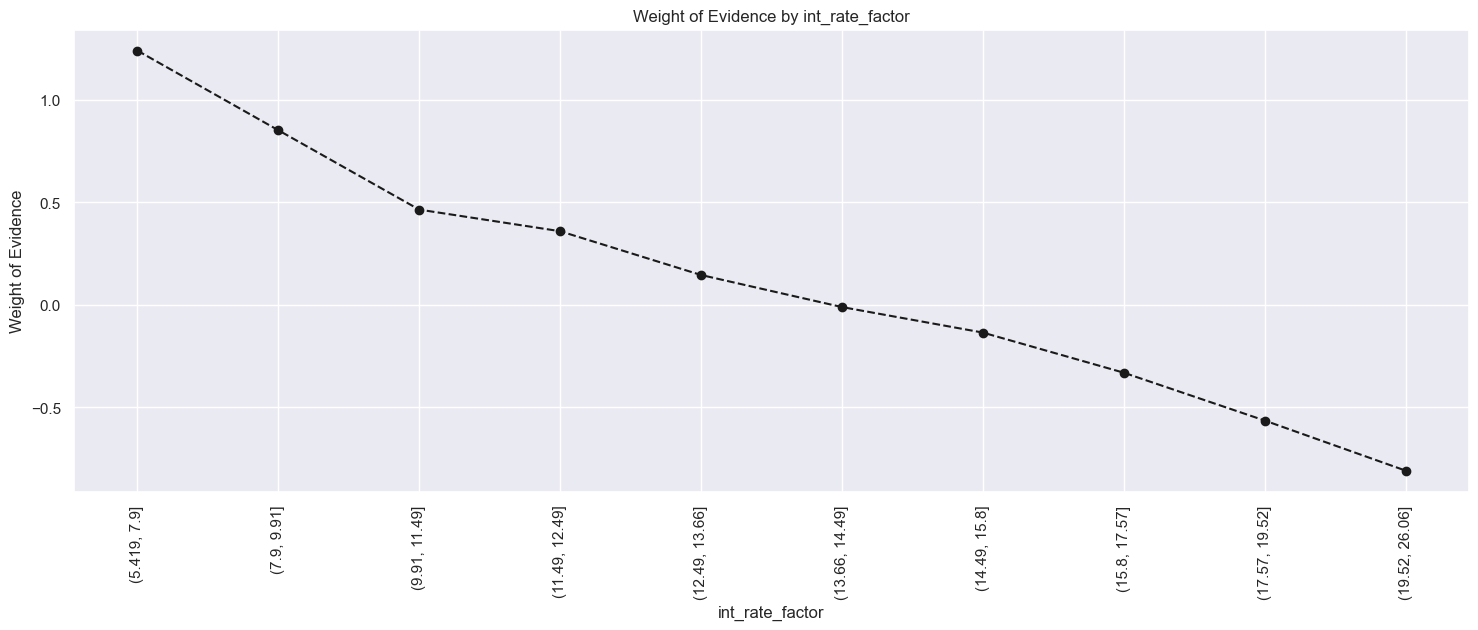

In [35]:
plot_by_woe(woe_continuous('int_rate_factor'), 90)

In [36]:
# '< 9.548', '9.548 - 12.025', '12.025 - 15.74', '15.74 - 20.281', '> 20.281'

df['int_rate:<9.548'] = np.where((df['int_rate'] <= 9.548), 1, 0)
df['int_rate:9.548-12.025'] = np.where((df['int_rate'] > 9.548) & (df['int_rate'] <= 12.025), 1, 0)
df['int_rate:12.025-15.74'] = np.where((df['int_rate'] > 12.025) & (df['int_rate'] <= 15.74), 1, 0)
df['int_rate:15.74-20.281'] = np.where((df['int_rate'] > 15.74) & (df['int_rate'] <= 20.281), 1, 0)
df['int_rate:>20.281'] = np.where((df['int_rate'] > 20.281), 1, 0)

<h4> Funded Amount </h4>

In [37]:
# funded_amnt
df['funded_amnt_factor'] = pd.qcut(df['funded_amnt'], 10)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.

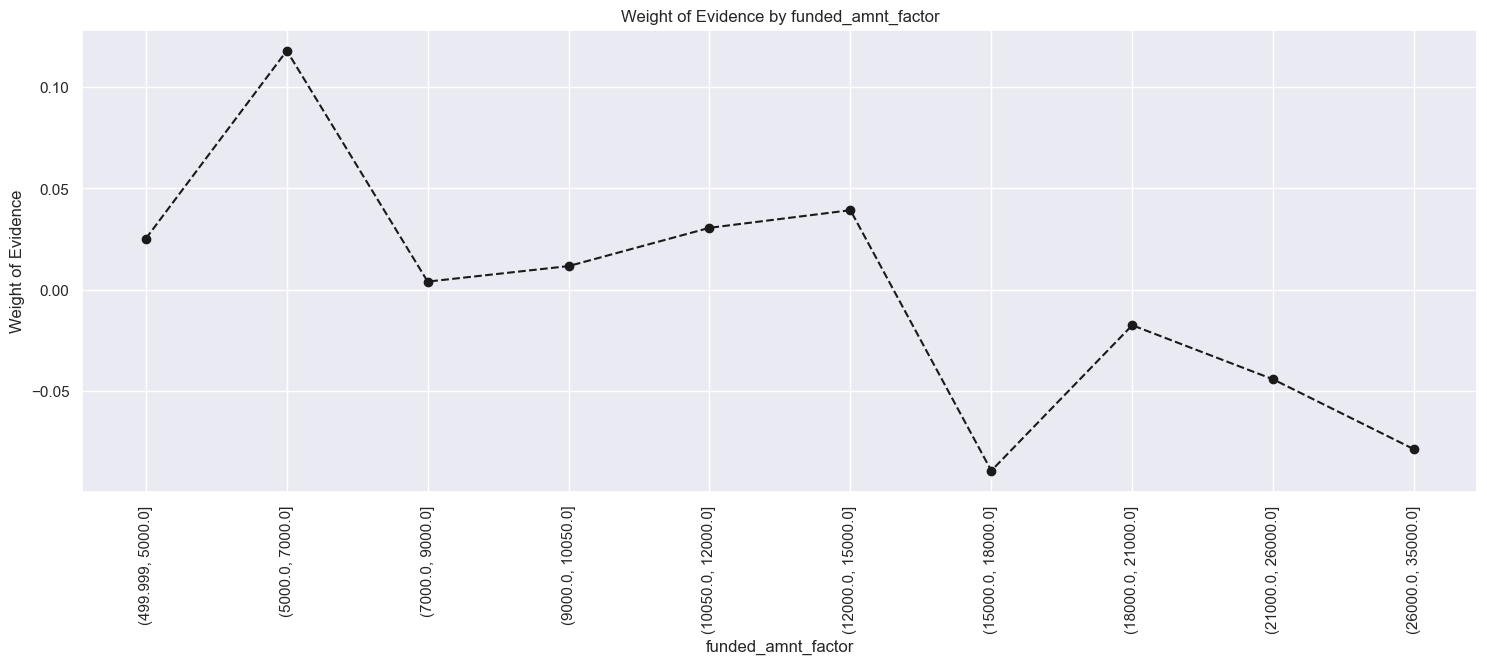

In [38]:
plot_by_woe(woe_continuous('funded_amnt_factor'), 90)
# We plot the weight of evidence values.

<h4> Months since earliest credit line </h4>

In [39]:
# mths_since_earliest_cr_line
df['mths_since_earliest_cr_line_factor'] = pd.qcut(df['months_since_earliest_cr_line'], 10)

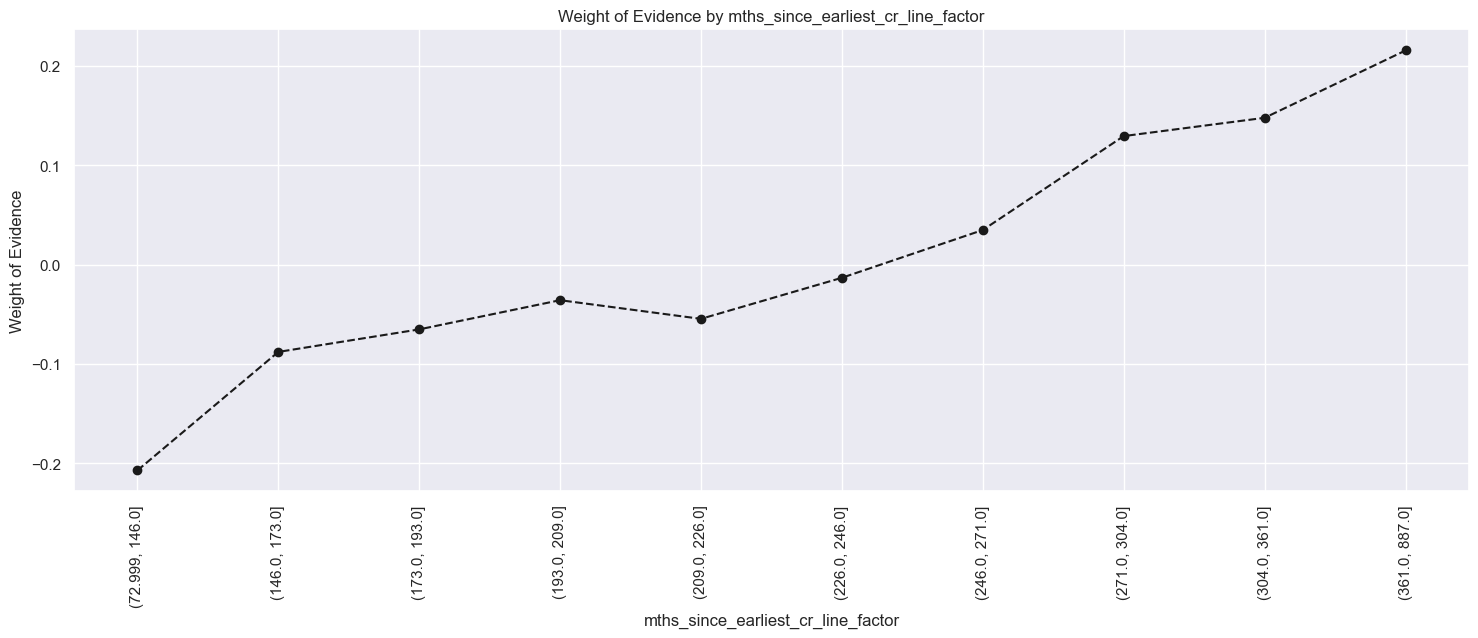

In [40]:
plot_by_woe(woe_continuous('mths_since_earliest_cr_line_factor'), 90)
# We plot the weight of evidence values.

In [41]:
# We create the following categories:
# < 140, # 141 - 164, # 165 - 247, # 248 - 270, # 271 - 352, # > 352
df['mths_since_earliest_cr_line:<140'] = np.where(df['months_since_earliest_cr_line'].isin(range(140)), 1, 0)
df['mths_since_earliest_cr_line:141-164'] = np.where(df['months_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
df['mths_since_earliest_cr_line:165-247'] = np.where(df['months_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
df['mths_since_earliest_cr_line:248-270'] = np.where(df['months_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
df['mths_since_earliest_cr_line:271-352'] = np.where(df['months_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
df['mths_since_earliest_cr_line:>352'] = np.where(df['months_since_earliest_cr_line'] >= 353, 1, 0)

<h4> Delinq_2_years </h4>

In [42]:
# delinq_2yrs
# woe_continuous('delinq_2yrs')

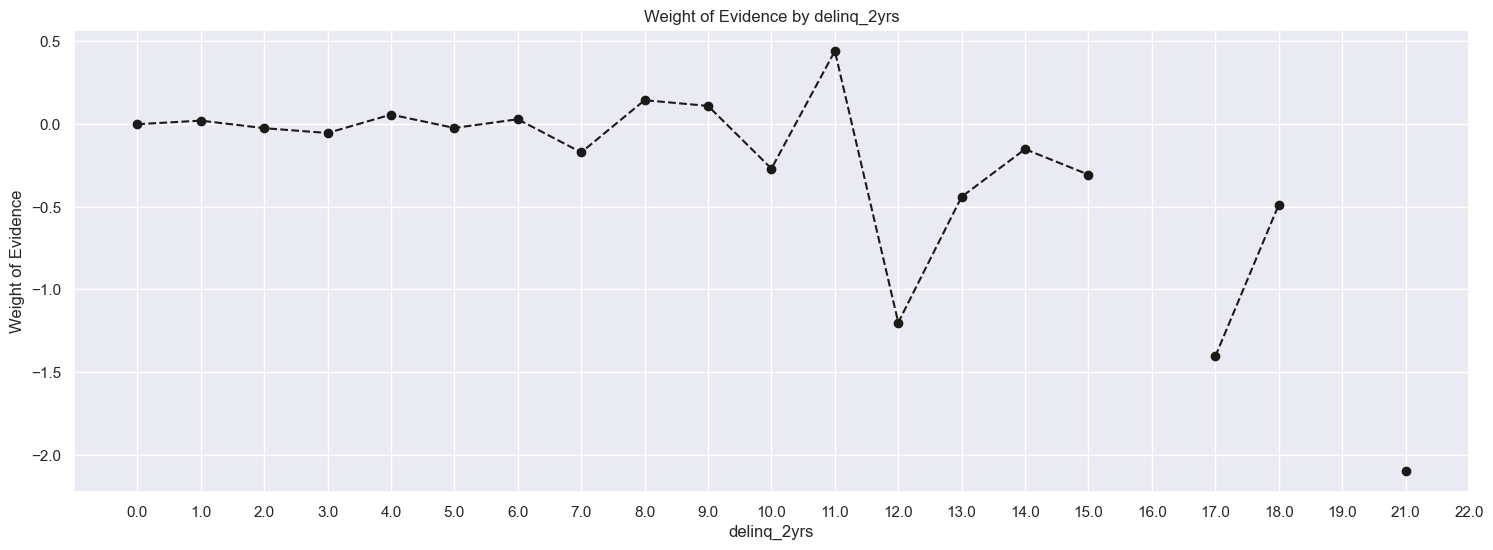

In [43]:
plot_by_woe(woe_continuous('delinq_2yrs'))

In [44]:
# Categories: 0, 1-3, >=4
df['delinq_2yrs:0'] = np.where((df['delinq_2yrs'] == 0), 1, 0)
df['delinq_2yrs:1-3'] = np.where((df['delinq_2yrs'] >= 1) & (df['delinq_2yrs'] <= 3), 1, 0)
df['delinq_2yrs:>=4'] = np.where((df['delinq_2yrs'] >= 4), 1, 0)

<h4> Inq_last_6_months </h4>

In [45]:
# woe_continuous('inq_last_6mths')

C:\Users\ngchi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


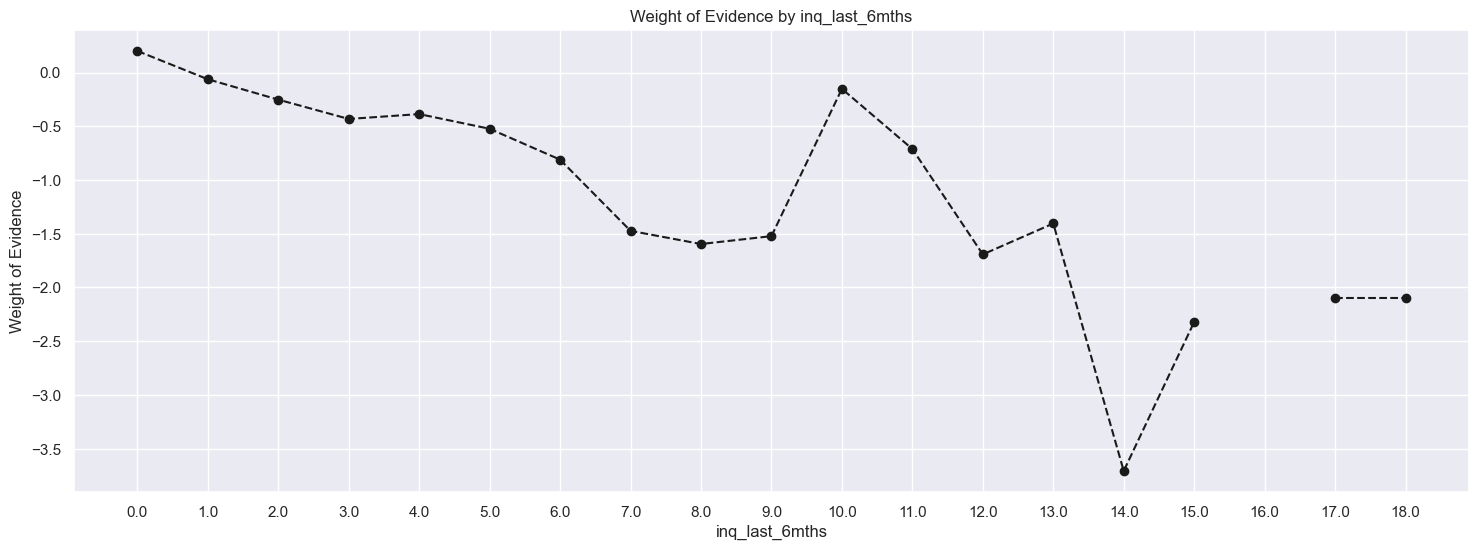

In [46]:
plot_by_woe(woe_continuous('inq_last_6mths'))

In [47]:
# Categories: 0, 1 - 2, 3 - 6, > 6
df['inq_last_6mths:0'] = np.where((df['inq_last_6mths'] == 0), 1, 0)
df['inq_last_6mths:1-2'] = np.where((df['inq_last_6mths'] >= 1) & (df['inq_last_6mths'] <= 2), 1, 0)
df['inq_last_6mths:3-6'] = np.where((df['inq_last_6mths'] >= 3) & (df['inq_last_6mths'] <= 6), 1, 0)
df['inq_last_6mths:>6'] = np.where((df['inq_last_6mths'] > 6), 1, 0)

<h4> Open Acc </h4>

In [48]:
woe_continuous('open_acc')

C:\Users\ngchi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,open_acc,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,0.0,7,0.571429,0.428571,4.0,3.0,0.000078,0.000007,-2.385522,-0.000071,inf
1,1.0,142,0.126761,0.873239,18.0,124.0,0.000353,0.000299,-0.167931,-0.000055,inf
2,2.0,1790,0.155866,0.844134,279.0,1511.0,0.005474,0.003638,-0.408525,-0.001836,inf
3,3.0,5500,0.130545,0.869455,718.0,4782.0,0.014088,0.011515,-0.201696,-0.002573,inf
4,4.0,12588,0.108357,0.891643,1364.0,11224.0,0.026763,0.027027,0.009792,0.000263,inf
...,...,...,...,...,...,...,...,...,...,...,...
57,61.0,1,0.000000,1.000000,0.0,1.0,0.000000,0.000002,inf,0.000002,inf
58,62.0,1,0.000000,1.000000,0.0,1.0,0.000000,0.000002,inf,0.000002,inf
59,75.0,1,0.000000,1.000000,0.0,1.0,0.000000,0.000002,inf,0.000002,inf
60,76.0,2,1.000000,0.000000,2.0,0.0,0.000039,0.000000,-inf,-0.000039,inf


C:\Users\ngchi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


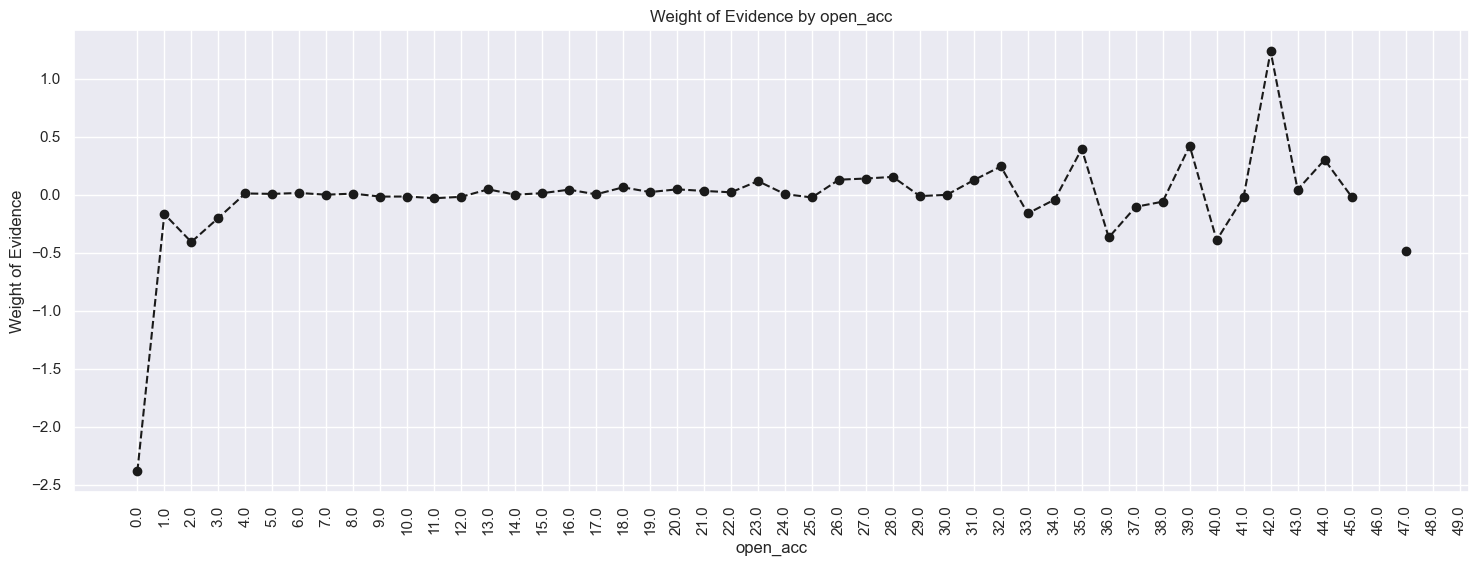

In [49]:
plot_by_woe(woe_continuous('open_acc'), 90)

In [50]:
# Categories: '0', '1-3', '4-12', '13-17', '18-22', '23-25', '26-30', '>30'
df['open_acc:0'] = np.where((df['open_acc'] == 0), 1, 0)
df['open_acc:1-3'] = np.where((df['open_acc'] >= 1) & (df['open_acc'] <= 3), 1, 0)
df['open_acc:4-12'] = np.where((df['open_acc'] >= 4) & (df['open_acc'] <= 12), 1, 0)
df['open_acc:13-17'] = np.where((df['open_acc'] >= 13) & (df['open_acc'] <= 17), 1, 0)
df['open_acc:18-22'] = np.where((df['open_acc'] >= 18) & (df['open_acc'] <= 22), 1, 0)
df['open_acc:23-25'] = np.where((df['open_acc'] >= 23) & (df['open_acc'] <= 25), 1, 0)
df['open_acc:26-30'] = np.where((df['open_acc'] >= 26) & (df['open_acc'] <= 30), 1, 0)
df['open_acc:>=31'] = np.where((df['open_acc'] >= 31), 1, 0)

<h4> Pub Rec </h4>

In [51]:
woe_continuous('pub_rec')

,pub_rec,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,0.0,404893,0.110212,0.889788,44624.0,360269.0,0.875581,0.867510,-0.009261,-0.008072,inf
1,1.0,53051,0.105031,0.894969,5572.0,47479.0,0.109330,0.114327,0.044693,0.004997,inf
2,2.0,5624,0.096550,0.903450,543.0,5081.0,0.010654,0.012235,0.138314,0.001580,inf
3,3.0,1611,0.083799,0.916201,135.0,1476.0,0.002649,0.003554,0.293976,0.000905,inf
4,4.0,520,0.090385,0.909615,47.0,473.0,0.000922,0.001139,0.211107,0.000217,inf
5,5.0,276,0.090580,0.909420,25.0,251.0,0.000491,0.000604,0.208737,0.000114,inf
6,6.0,136,0.073529,0.926471,10.0,126.0,0.000196,0.000303,0.435856,0.000107,inf
7,7.0,62,0.080645,0.919355,5.0,57.0,0.000098,0.000137,0.335773,0.000039,inf
8,8.0,29,0.034483,0.965517,1.0,28.0,0.000020,0.000067,1.234364,0.000048,inf
9,9.0,16,0.187500,0.812500,3.0,13.0,0.000059,0.000031,-0.631503,-0.000028,inf


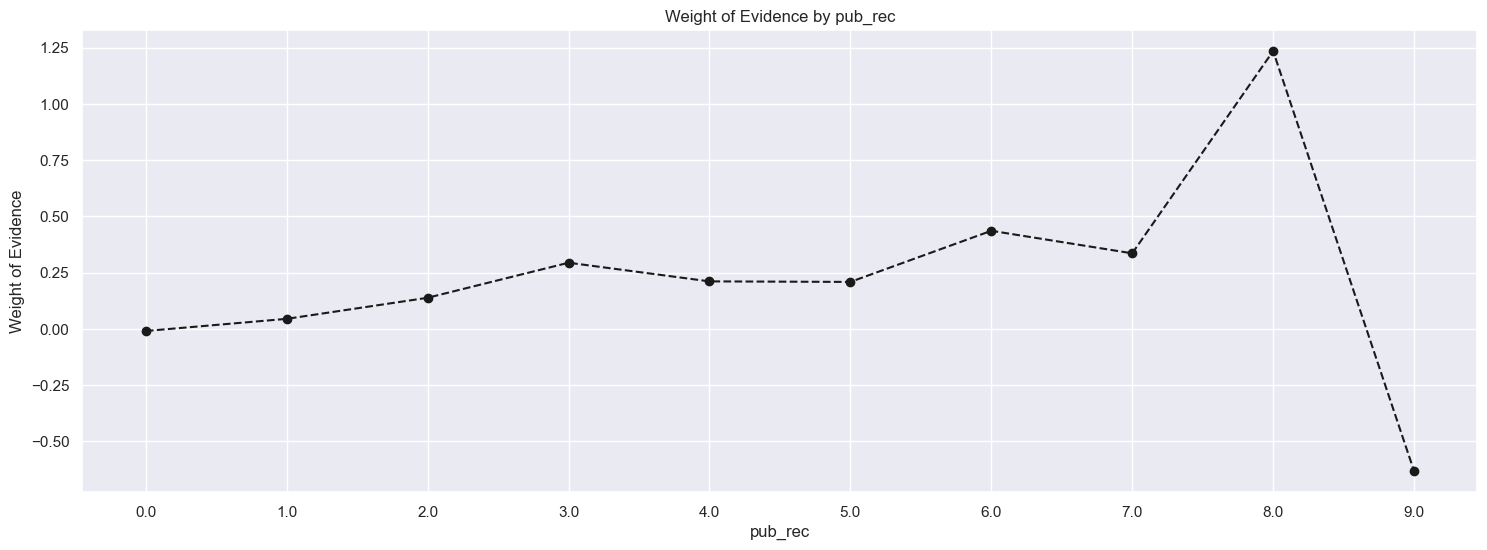

In [52]:
plot_by_woe(woe_continuous('pub_rec'))

In [53]:
# Categories '0-2', '3-4', '>=5'
df['pub_rec:0-2'] = np.where((df['pub_rec'] >= 0) & (df['pub_rec'] <= 2), 1, 0)
df['pub_rec:3-4'] = np.where((df['pub_rec'] >= 3) & (df['pub_rec'] <= 4), 1, 0)
df['pub_rec:>=5'] = np.where((df['pub_rec'] >= 5), 1, 0)

<h4> Total Acc Factor </h4>

In [54]:
df['total_acc_factor'] = pd.qcut(df['total_acc'], 10)
# woe_continuous('total_acc_factor')

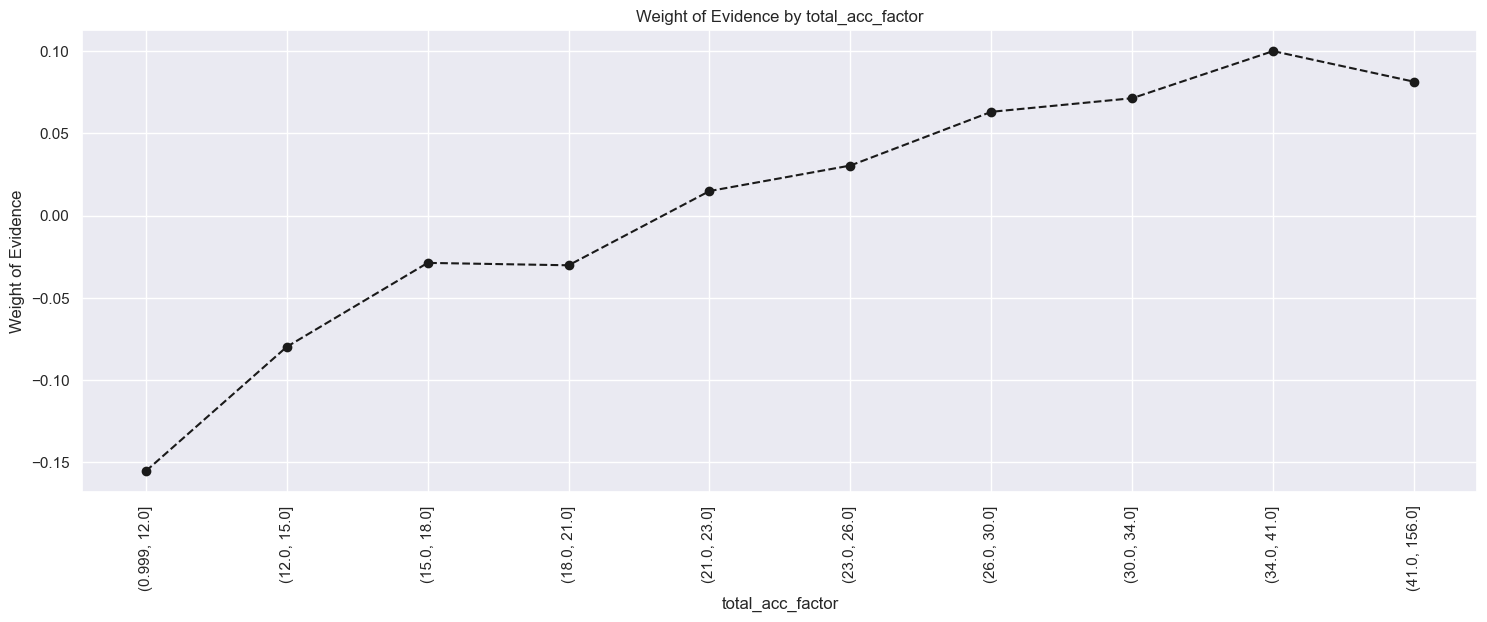

In [55]:
plot_by_woe(woe_continuous('total_acc_factor'), 90)

In [56]:
# Categories: '<=27', '28-51', '>51'
df['total_acc:<=27'] = np.where((df['total_acc'] <= 27), 1, 0)
df['total_acc:28-51'] = np.where((df['total_acc'] >= 28) & (df['total_acc'] <= 51), 1, 0)
df['total_acc:>=52'] = np.where((df['total_acc'] >= 52), 1, 0)

<h4> Acc Now Delinq </h4>

In [57]:
woe_continuous('acc_now_delinq')

,acc_now_delinq,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,0.0,464524,0.109316,0.890684,50780.0,413744.0,0.996370,0.996275,-0.000096,-0.000095,inf
1,1.0,1623,0.106593,0.893407,173.0,1450.0,0.003394,0.003492,0.028187,0.000097,inf
2,2.0,92,0.097826,0.902174,9.0,83.0,0.000177,0.000200,0.123776,0.000023,inf
3,3.0,11,0.181818,0.818182,2.0,9.0,0.000039,0.000022,-0.593763,-0.000018,inf
4,4.0,4,0.000000,1.000000,0.0,4.0,0.000000,0.000010,inf,0.000010,inf
5,5.0,2,0.500000,0.500000,1.0,1.0,0.000020,0.000002,-2.097840,-0.000017,inf


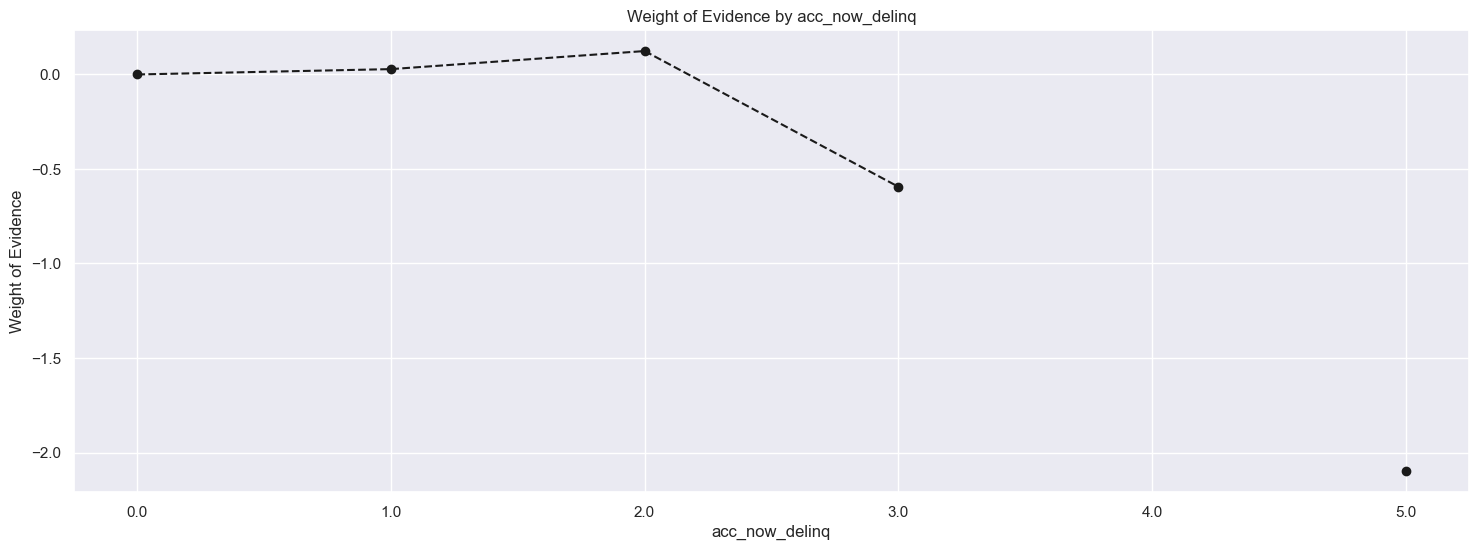

In [58]:
plot_by_woe(woe_continuous('acc_now_delinq'))

In [59]:
# Categories: '0', '>=1'
df['acc_now_delinq:0'] = np.where((df['acc_now_delinq'] == 0), 1, 0)
df['acc_now_delinq:>=1'] = np.where((df['acc_now_delinq'] >= 1), 1, 0)

<h4> Total Rev Hi Limit </h4>

In [60]:
df['total_rev_hi_lim_factor'] = pd.qcut(df['total_rev_hi_lim'], 10)
woe_continuous('total_rev_hi_lim_factor')

,total_rev_hi_lim_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-0.001, 6700.0]",47194,0.131436,0.868564,6203.0,40991.0,0.121711,0.098704,-0.209521,-0.023007,0.041803
1,"(6700.0, 10000.0]",49341,0.123974,0.876026,6117.0,43224.0,0.120024,0.104081,-0.142516,-0.015942,0.041803
2,"(10000.0, 13100.0]",43959,0.119202,0.880798,5240.0,38719.0,0.102816,0.093233,-0.097831,-0.009582,0.041803
3,"(13100.0, 16400.0]",46710,0.122608,0.877392,5727.0,40983.0,0.112371,0.098685,-0.129875,-0.013686,0.041803
4,"(16400.0, 20100.0]",46592,0.120385,0.879615,5609.0,40983.0,0.110056,0.098685,-0.109055,-0.011371,0.041803
5,"(20100.0, 24800.0]",46158,0.110490,0.889510,5100.0,41058.0,0.100069,0.098866,-0.012095,-0.001203,0.041803
6,"(24800.0, 30600.0]",46449,0.110487,0.889513,5132.0,41317.0,0.100697,0.099489,-0.012062,-0.001207,0.041803
7,"(30600.0, 39200.0]",46908,0.101134,0.898866,4744.0,42164.0,0.093083,0.101529,0.086846,0.008445,0.041803
8,"(39200.0, 54600.0]",46403,0.085986,0.914014,3990.0,42413.0,0.078289,0.102128,0.265823,0.023839,0.041803
9,"(54600.0, 9999999.0]",46542,0.066671,0.933329,3103.0,43439.0,0.060885,0.104599,0.541148,0.043714,0.041803


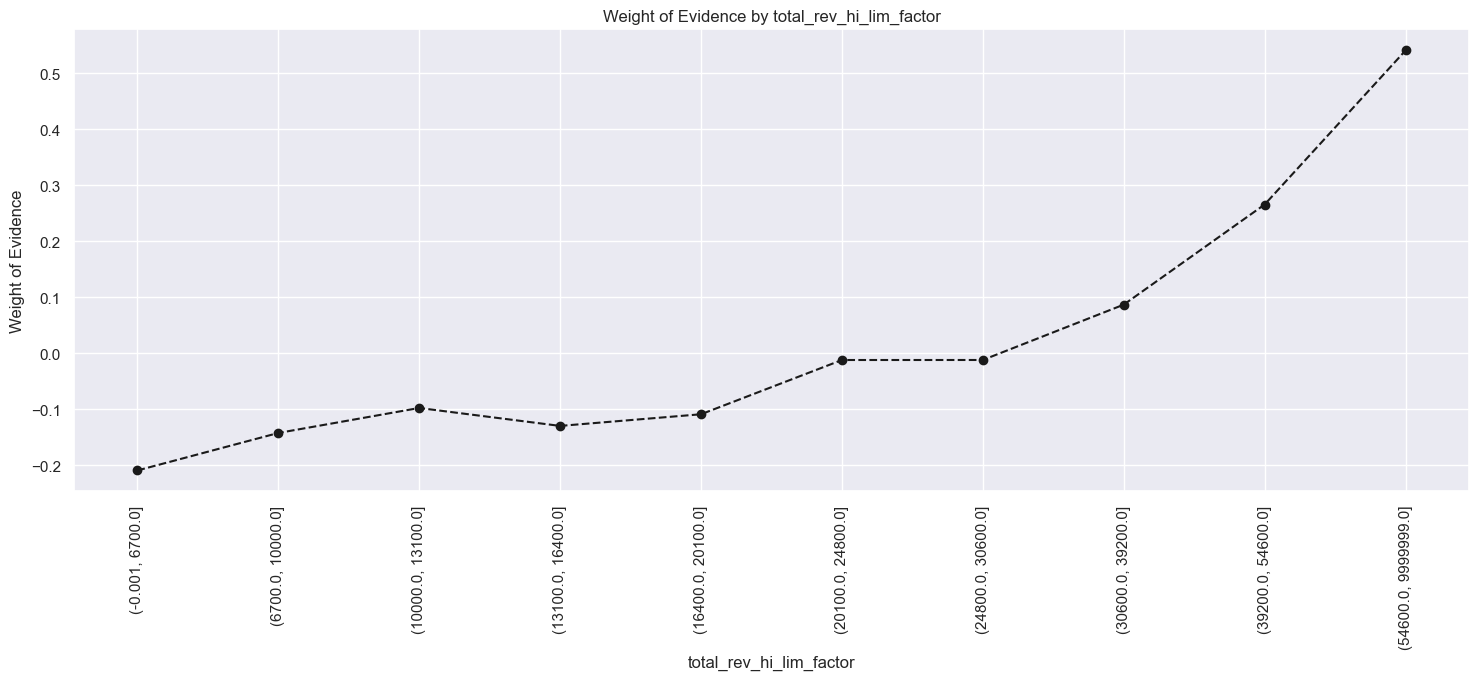

In [61]:
plot_by_woe(woe_continuous('total_rev_hi_lim_factor'), 90)

In [62]:
# Categories
# '<=5K', '5K-10K', '10K-20K', '20K-30K', '30K-40K', '40K-55K', '55K-95K', '>95K'
df['total_rev_hi_lim:<=5K'] = np.where((df['total_rev_hi_lim'] <= 5000), 1, 0)
df['total_rev_hi_lim:5K-10K'] = np.where((df['total_rev_hi_lim'] > 5000) & (df['total_rev_hi_lim'] <= 10000), 1, 0)
df['total_rev_hi_lim:10K-20K'] = np.where((df['total_rev_hi_lim'] > 10000) & (df['total_rev_hi_lim'] <= 20000), 1, 0)
df['total_rev_hi_lim:20K-30K'] = np.where((df['total_rev_hi_lim'] > 20000) & (df['total_rev_hi_lim'] <= 30000), 1, 0)
df['total_rev_hi_lim:30K-40K'] = np.where((df['total_rev_hi_lim'] > 30000) & (df['total_rev_hi_lim'] <= 40000), 1, 0)
df['total_rev_hi_lim:40K-55K'] = np.where((df['total_rev_hi_lim'] > 40000) & (df['total_rev_hi_lim'] <= 55000), 1, 0)
df['total_rev_hi_lim:55K-95K'] = np.where((df['total_rev_hi_lim'] > 55000) & (df['total_rev_hi_lim'] <= 95000), 1, 0)
df['total_rev_hi_lim:>95K'] = np.where((df['total_rev_hi_lim'] > 95000), 1, 0)

<h4> Installment Factor </h4>

In [63]:
df['installment_factor'] = pd.cut(df['installment'], 10)
# woe_continuous('installment_factor')

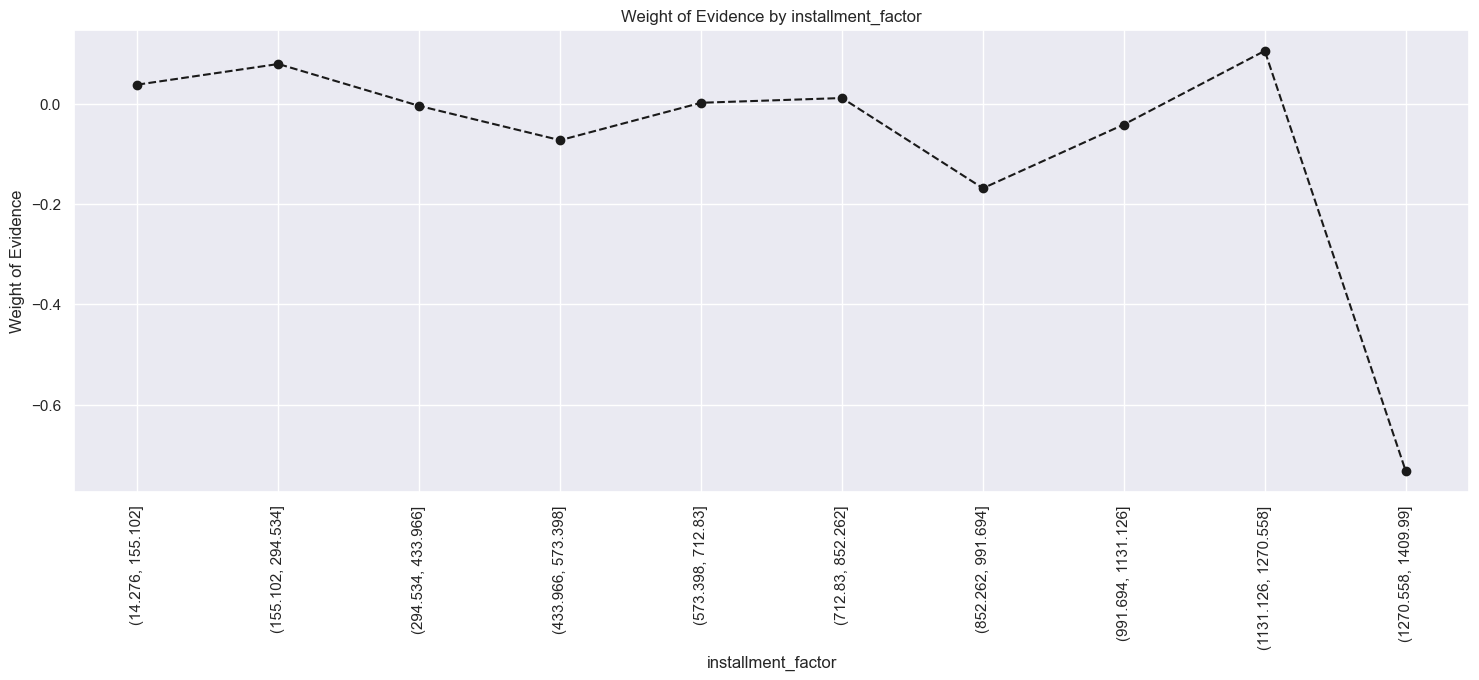

In [64]:
plot_by_woe(woe_continuous('installment_factor'), 90)

<h4> Annual Income Factor </h4>

In [65]:
df['annual_inc_factor'] = pd.cut(df['annual_inc'], 100)
woe_continuous('annual_inc_factor')

,annual_inc_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-5602.104, 76877.04]",306423,0.122641,0.877359,37580.0,268843.0,0.737369,0.647361,-0.130185,-0.090008,inf
1,"(76877.04, 151858.08]",139393,0.085413,0.914587,11906.0,127487.0,0.233611,0.306982,0.273132,0.073371,inf
2,"(151858.08, 226839.12]",14865,0.073125,0.926875,1087.0,13778.0,0.021328,0.033177,0.441811,0.011848,inf
3,"(226839.12, 301820.16]",3558,0.072794,0.927206,259.0,3299.0,0.005082,0.007944,0.446706,0.002862,inf
4,"(301820.16, 376801.2]",867,0.070358,0.929642,61.0,806.0,0.001197,0.001941,0.483370,0.000744,inf
...,...,...,...,...,...,...,...,...,...,...,...
95,"(7125094.8, 7200075.84]",1,0.000000,1.000000,0.0,1.0,0.000000,0.000002,inf,0.000002,inf
96,"(7200075.84, 7275056.88]",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
97,"(7275056.88, 7350037.92]",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
98,"(7350037.92, 7425018.96]",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


In [66]:
df_temp = df.loc[df['annual_inc'] <= 140000, : ]

In [67]:
df_temp["annual_inc_factor"] = pd.cut(df_temp['annual_inc'], 10)
woe_continuous('annual_inc_factor')

C:\Users\ngchi\AppData\Local\Temp\ipykernel_4052\439517141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["annual_inc_factor"] = pd.cut(df_temp['annual_inc'], 10)


,annual_inc_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-5602.104, 76877.04]",306423,0.122641,0.877359,37580.0,268843.0,0.737369,0.647361,-0.130185,-0.090008,inf
1,"(76877.04, 151858.08]",139393,0.085413,0.914587,11906.0,127487.0,0.233611,0.306982,0.273132,0.073371,inf
2,"(151858.08, 226839.12]",14865,0.073125,0.926875,1087.0,13778.0,0.021328,0.033177,0.441811,0.011848,inf
3,"(226839.12, 301820.16]",3558,0.072794,0.927206,259.0,3299.0,0.005082,0.007944,0.446706,0.002862,inf
4,"(301820.16, 376801.2]",867,0.070358,0.929642,61.0,806.0,0.001197,0.001941,0.483370,0.000744,inf
...,...,...,...,...,...,...,...,...,...,...,...
95,"(7125094.8, 7200075.84]",1,0.000000,1.000000,0.0,1.0,0.000000,0.000002,inf,0.000002,inf
96,"(7200075.84, 7275056.88]",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
97,"(7275056.88, 7350037.92]",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
98,"(7350037.92, 7425018.96]",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


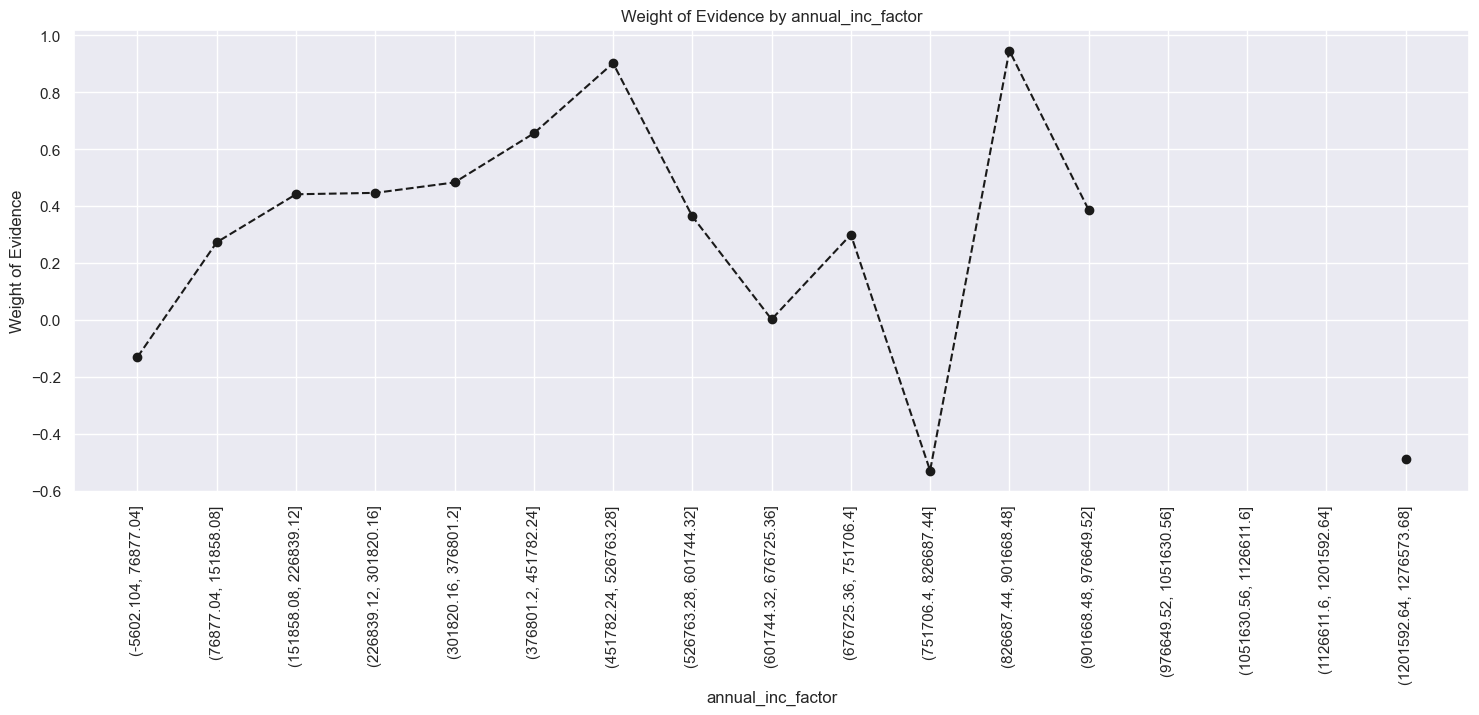

In [68]:
plot_by_woe(woe_continuous('annual_inc_factor'), 90)

In [69]:
# WoE is monotonically decreasing with income, so we split income in 10 equal categories, each with width of 15k.
df['annual_inc:<20K'] = np.where((df['annual_inc'] <= 20000), 1, 0)
df['annual_inc:20K-30K'] = np.where((df['annual_inc'] > 20000) & (df['annual_inc'] <= 30000), 1, 0)
df['annual_inc:30K-40K'] = np.where((df['annual_inc'] > 30000) & (df['annual_inc'] <= 40000), 1, 0)
df['annual_inc:40K-50K'] = np.where((df['annual_inc'] > 40000) & (df['annual_inc'] <= 50000), 1, 0)
df['annual_inc:50K-60K'] = np.where((df['annual_inc'] > 50000) & (df['annual_inc'] <= 60000), 1, 0)
df['annual_inc:60K-70K'] = np.where((df['annual_inc'] > 60000) & (df['annual_inc'] <= 70000), 1, 0)
df['annual_inc:70K-80K'] = np.where((df['annual_inc'] > 70000) & (df['annual_inc'] <= 80000), 1, 0)
df['annual_inc:80K-90K'] = np.where((df['annual_inc'] > 80000) & (df['annual_inc'] <= 90000), 1, 0)
df['annual_inc:90K-100K'] = np.where((df['annual_inc'] > 90000) & (df['annual_inc'] <= 100000), 1, 0)
df['annual_inc:100K-120K'] = np.where((df['annual_inc'] > 100000) & (df['annual_inc'] <= 120000), 1, 0)
df['annual_inc:120K-140K'] = np.where((df['annual_inc'] > 120000) & (df['annual_inc'] <= 140000), 1, 0)
df['annual_inc:>140K'] = np.where((df['annual_inc'] > 140000), 1, 0)

<h4> Months since last delinq </h4>

In [70]:
df['mths_since_last_delinq_factor'] = pd.cut(df['mths_since_last_delinq'], 10)
woe_continuous('mths_since_last_delinq_factor')

,mths_since_last_delinq_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-0.188, 18.8]",65341,0.111645,0.888355,7295.0,58046.0,0.313305,0.301303,-0.039062,-0.012002,inf
1,"(18.8, 37.6]",63013,0.103788,0.896212,6540.0,56473.0,0.280880,0.293138,0.042717,0.012258,inf
2,"(37.6, 56.4]",46976,0.107225,0.892775,5037.0,41939.0,0.216329,0.217695,0.006297,0.001366,inf
3,"(56.4, 75.2]",31602,0.107683,0.892317,3403.0,28199.0,0.146152,0.146374,0.001520,0.000222,inf
4,"(75.2, 94.0]",8884,0.111774,0.888226,993.0,7891.0,0.042647,0.040960,-0.040361,-0.001687,inf
5,"(94.0, 112.8]",69,0.159420,0.840580,11.0,58.0,0.000472,0.000301,-0.450561,-0.000171,inf
6,"(112.8, 131.6]",24,0.041667,0.958333,1.0,23.0,0.000043,0.000119,1.022386,0.000076,inf
7,"(131.6, 150.4]",18,0.166667,0.833333,3.0,15.0,0.000129,0.000078,-0.503671,-0.000051,inf
8,"(150.4, 169.2]",4,0.250000,0.750000,1.0,3.0,0.000043,0.000016,-1.014496,-0.000027,inf
9,"(169.2, 188.0]",3,0.000000,1.000000,0.0,3.0,0.000000,0.000016,inf,0.000016,inf


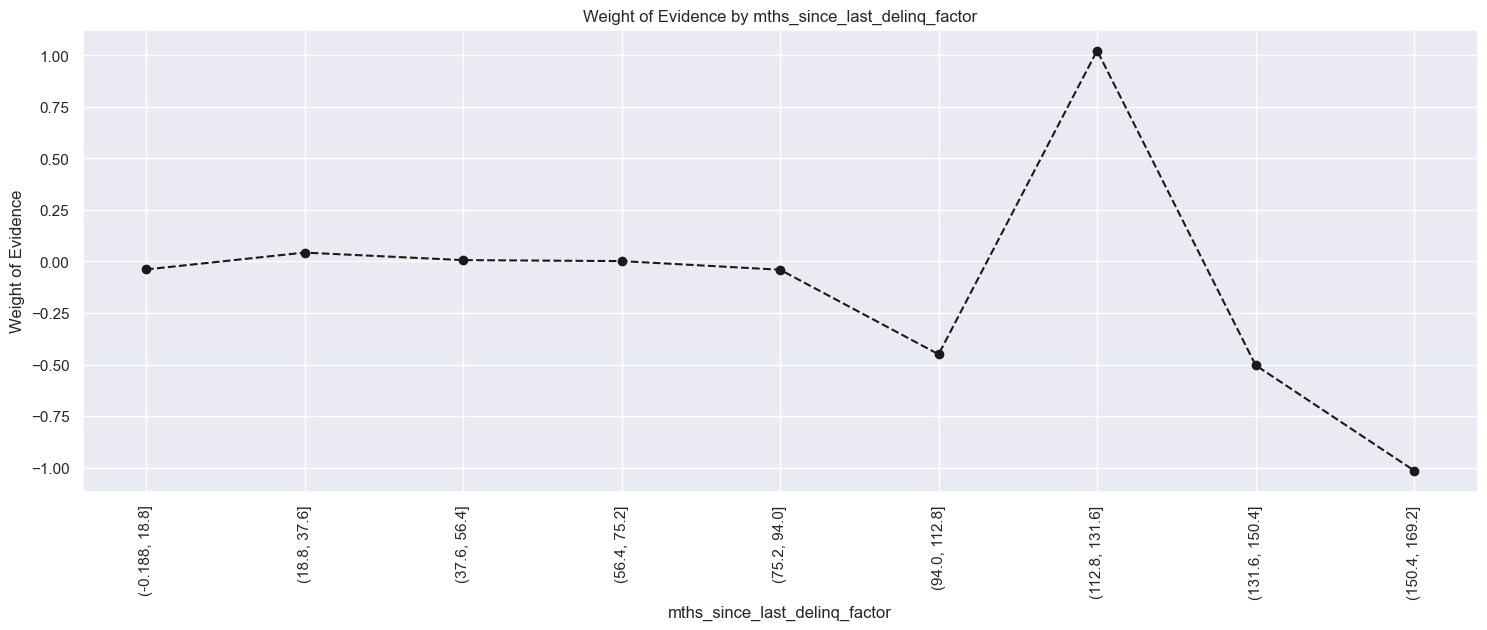

In [71]:
plot_by_woe(woe_continuous('mths_since_last_delinq_factor'), 90)
# We plot the weight of evidence values.

In [72]:
# Categories: Missing, 0-3, 4-30, 31-56, >=57
df['mths_since_last_delinq:Missing'] = np.where((df['mths_since_last_delinq'].isnull()), 1, 0)
df['mths_since_last_delinq:0-3'] = np.where((df['mths_since_last_delinq'] >= 0) & (df['mths_since_last_delinq'] <= 3), 1, 0)
df['mths_since_last_delinq:4-30'] = np.where((df['mths_since_last_delinq'] >= 4) & (df['mths_since_last_delinq'] <= 30), 1, 0)
df['mths_since_last_delinq:31-56'] = np.where((df['mths_since_last_delinq'] >= 31) & (df['mths_since_last_delinq'] <= 56), 1, 0)
df['mths_since_last_delinq:>=57'] = np.where((df['mths_since_last_delinq'] >= 57), 1, 0)

<h4> DTI Factor </h4>

In [73]:
df['dti_factor'] = pd.cut(df['dti'], 10)
woe_continuous('dti_factor')

,dti_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-0.04, 3.999]",16721,0.093655,0.906345,1566.0,15155.0,0.030727,0.036492,0.171966,0.005766,0.026037
1,"(3.999, 7.998]",42958,0.086014,0.913986,3695.0,39263.0,0.072501,0.094543,0.265462,0.022043,0.026037
2,"(7.998, 11.997]",69295,0.092604,0.907396,6417.0,62878.0,0.125910,0.151407,0.184405,0.025497,0.026037
3,"(11.997, 15.996]",85369,0.099544,0.900456,8498.0,76871.0,0.166742,0.185102,0.104457,0.018360,0.026037
4,"(15.996, 19.995]",84087,0.111611,0.888389,9385.0,74702.0,0.184146,0.179879,-0.023446,-0.004267,0.026037
5,"(19.995, 23.994]",71058,0.122984,0.877016,8739.0,62319.0,0.171471,0.150061,-0.133370,-0.021410,0.026037
6,"(23.994, 27.993]",50073,0.129271,0.870729,6473.0,43600.0,0.127009,0.104987,-0.190423,-0.022022,0.026037
7,"(27.993, 31.992]",30288,0.133518,0.866482,4044.0,26244.0,0.079349,0.063194,-0.227637,-0.016154,0.026037
8,"(31.992, 35.991]",13654,0.134027,0.865973,1830.0,11824.0,0.035907,0.028472,-0.232025,-0.007435,0.026037
9,"(35.991, 39.99]",2753,0.115510,0.884490,318.0,2435.0,0.006240,0.005863,-0.062190,-0.000376,0.026037


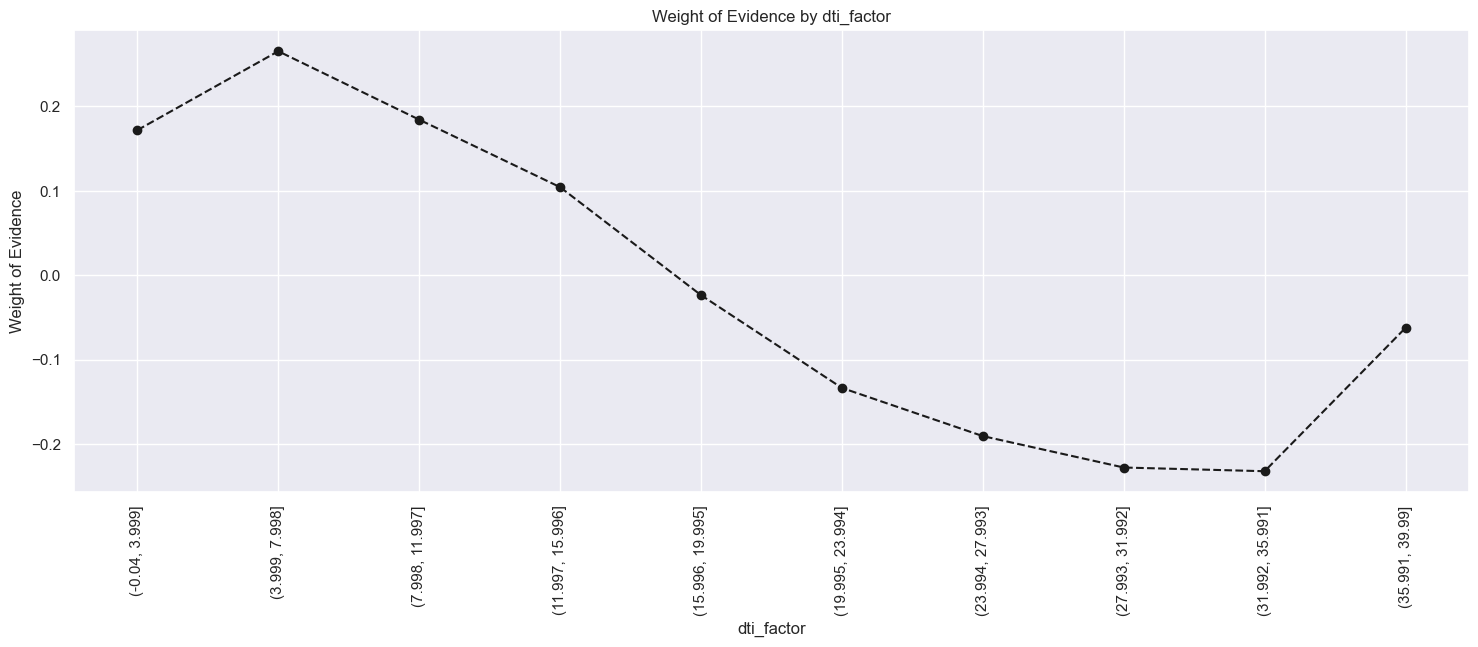

In [74]:
plot_by_woe(woe_continuous('dti_factor'), 90)

In [75]:
# Categories:
df['dti:<=1.4'] = np.where((df['dti'] <= 1.4), 1, 0)
df['dti:1.4-3.5'] = np.where((df['dti'] > 1.4) & (df['dti'] <= 3.5), 1, 0)
df['dti:3.5-7.7'] = np.where((df['dti'] > 3.5) & (df['dti'] <= 7.7), 1, 0)
df['dti:7.7-10.5'] = np.where((df['dti'] > 7.7) & (df['dti'] <= 10.5), 1, 0)
df['dti:10.5-16.1'] = np.where((df['dti'] > 10.5) & (df['dti'] <= 16.1), 1, 0)
df['dti:16.1-20.3'] = np.where((df['dti'] > 16.1) & (df['dti'] <= 20.3), 1, 0)
df['dti:20.3-21.7'] = np.where((df['dti'] > 20.3) & (df['dti'] <= 21.7), 1, 0)
df['dti:21.7-22.4'] = np.where((df['dti'] > 21.7) & (df['dti'] <= 22.4), 1, 0)
df['dti:22.4-35'] = np.where((df['dti'] > 22.4) & (df['dti'] <= 35), 1, 0)
df['dti:>35'] = np.where((df['dti'] > 35), 1, 0)

<h4> Mths since last record </h4>

In [76]:
df['mths_since_last_record_factor'] = pd.cut(df['mths_since_last_record'], 10)
woe_continuous('mths_since_last_record_factor')

,mths_since_last_record_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-0.129, 12.9]",2200,0.182273,0.817727,401.0,1799.0,0.060265,0.032134,-0.628823,-0.028130,0.058122
1,"(12.9, 25.8]",2066,0.089061,0.910939,184.0,1882.0,0.027653,0.033617,0.195307,0.005964,0.058122
2,"(25.8, 38.7]",3963,0.083270,0.916730,330.0,3633.0,0.049594,0.064894,0.268874,0.015299,0.058122
3,"(38.7, 51.6]",6721,0.078262,0.921738,526.0,6195.0,0.079050,0.110657,0.336349,0.031606,0.058122
4,"(51.6, 64.5]",8950,0.086369,0.913631,773.0,8177.0,0.116171,0.146060,0.228954,0.029889,0.058122
5,"(64.5, 77.4]",8171,0.089952,0.910048,735.0,7436.0,0.110460,0.132824,0.184370,0.022364,0.058122
6,"(77.4, 90.3]",7077,0.120390,0.879610,852.0,6225.0,0.128043,0.111192,-0.141106,-0.016851,0.058122
7,"(90.3, 103.2]",9429,0.130024,0.869976,1226.0,8203.0,0.184250,0.146524,-0.229105,-0.037726,0.058122
8,"(103.2, 116.1]",12047,0.117374,0.882626,1414.0,10633.0,0.212504,0.189929,-0.112308,-0.022574,0.058122
9,"(116.1, 129.0]",2014,0.105760,0.894240,213.0,1801.0,0.032011,0.032170,0.004957,0.000159,0.058122


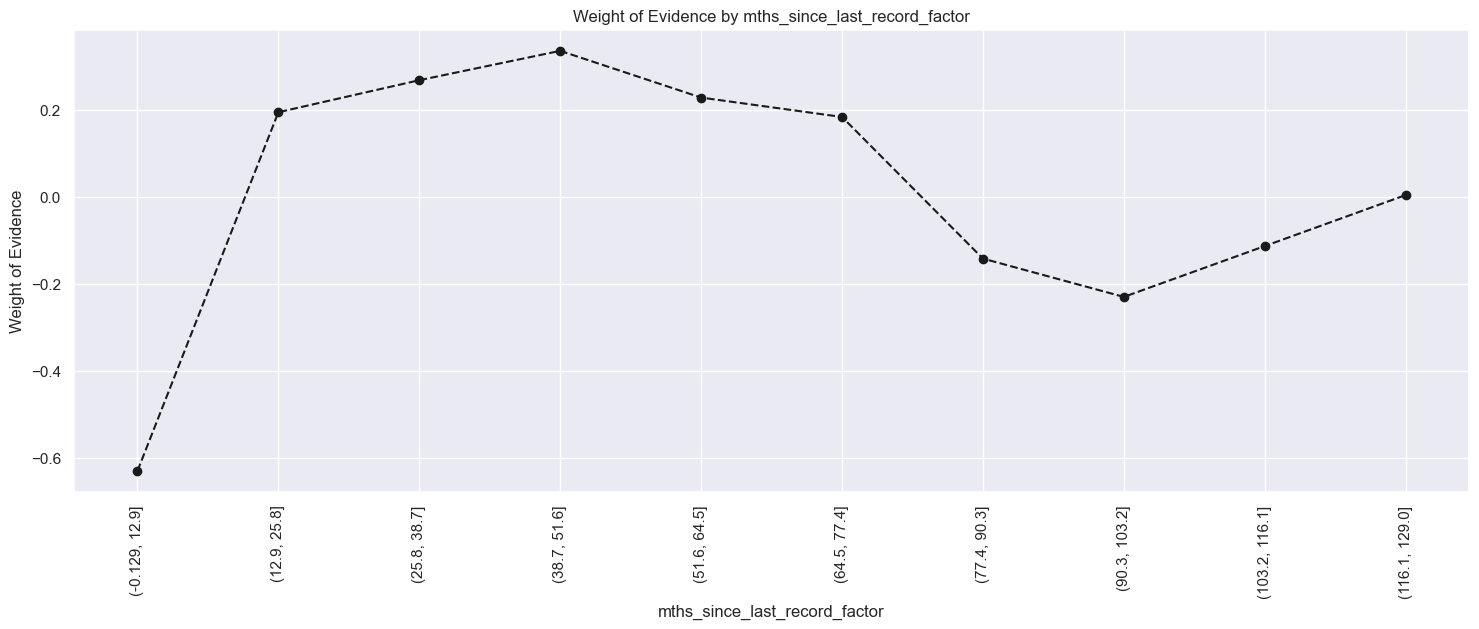

In [77]:
plot_by_woe(woe_continuous('mths_since_last_record_factor'), 90)

In [78]:
# Categories: 'Missing', '0-2', '3-20', '21-31', '32-80', '81-86', '>86'
df['mths_since_last_record:Missing'] = np.where((df['mths_since_last_record'].isnull()), 1, 0)
df['mths_since_last_record:0-2'] = np.where((df['mths_since_last_record'] >= 0) & (df['mths_since_last_record'] <= 2), 1, 0)
df['mths_since_last_record:3-20'] = np.where((df['mths_since_last_record'] >= 3) & (df['mths_since_last_record'] <= 20), 1, 0)
df['mths_since_last_record:21-31'] = np.where((df['mths_since_last_record'] >= 21) & (df['mths_since_last_record'] <= 31), 1, 0)
df['mths_since_last_record:32-80'] = np.where((df['mths_since_last_record'] >= 32) & (df['mths_since_last_record'] <= 80), 1, 0)
df['mths_since_last_record:81-86'] = np.where((df['mths_since_last_record'] >= 81) & (df['mths_since_last_record'] <= 86), 1, 0)
df['mths_since_last_record:>86'] = np.where((df['mths_since_last_record'] > 86), 1, 0)

<h3> Train-Test Split </h3>

In [80]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['good_bad'])
y = df['good_bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [81]:
# Here we select a limited set of input variables in a new dataframe.
X_train_ref_category = X_train.loc[: , ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'delinq_2yrs:0',
'delinq_2yrs:1-3',
'delinq_2yrs:>=4',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'open_acc:0',
'open_acc:1-3',
'open_acc:4-12',
'open_acc:13-17',
'open_acc:18-22',
'open_acc:23-25',
'open_acc:26-30',
'open_acc:>=31',
'pub_rec:0-2',
'pub_rec:3-4',
'pub_rec:>=5',
'total_acc:<=27',
'total_acc:28-51',
'total_acc:>=52',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'total_rev_hi_lim:<=5K',
'total_rev_hi_lim:5K-10K',
'total_rev_hi_lim:10K-20K',
'total_rev_hi_lim:20K-30K',
'total_rev_hi_lim:30K-40K',
'total_rev_hi_lim:40K-55K',
'total_rev_hi_lim:55K-95K',
'total_rev_hi_lim:>95K',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86',
]]

In [82]:
# Here we store the names of the reference category dummy variables in a list.
ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:NE_IA_NV_FL_HI_AL',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'delinq_2yrs:>=4',
'inq_last_6mths:>6',
'open_acc:0',
'pub_rec:0-2',
'total_acc:<=27',
'acc_now_delinq:0',
'total_rev_hi_lim:<=5K',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [83]:
X_train = X_train_ref_category.drop(ref_categories, axis = 1)
X_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,initial_list_status:w,term:36,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,delinq_2yrs:0,delinq_2yrs:1-3,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,open_acc:1-3,open_acc:4-12,open_acc:13-17,open_acc:18-22,open_acc:23-25,open_acc:26-30,open_acc:>=31,pub_rec:3-4,pub_rec:>=5,total_acc:28-51,total_acc:>=52,acc_now_delinq:>=1,total_rev_hi_lim:5K-10K,total_rev_hi_lim:10K-20K,total_rev_hi_lim:20K-30K,total_rev_hi_lim:30K-40K,total_rev_hi_lim:40K-55K,total_rev_hi_lim:55K-95K,total_rev_hi_lim:>95K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
154362,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
326671,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
418722,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
142720,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
15319,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1


<h3> Logistic Regression </h3>

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm

X_train = sm.add_constant(X_train)

#fitting log reg model
model = sm.Logit(y_train, X_train)
trained_model = model.fit()

print(trained_model.summary())

         Current function value: 0.320377
         Iterations: 35


C:\Users\ngchi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:               good_bad   No. Observations:               312391
Model:                          Logit   Df Residuals:                   312292
Method:                           MLE   Df Model:                           98
Date:                Sun, 30 Jul 2023   Pseudo R-squ.:                 0.07244
Time:                        22:55:30   Log-Likelihood:            -1.0008e+05
converged:                      False   LL-Null:                   -1.0790e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 -16.2024    1.4e+04     -0.001      0.999   -2.75e+04    2.75e+04
grade:A                                -1.0949      0.10

In [86]:
trained_model.pvalues.to_csv("p_values_of_each_variable_bin.csv")

<p> Remove variables with p-value > 5%, keep group that has maybe just a few that fail statistical sig test</p>

In [114]:
#delinq_2yrs
#open_acc
#pub_rec
#total_acc
#total_rev_hi_lim

X_train_remove_p_values = X_train.loc[:, ~X_train.columns.str.contains('delinq_2yrs')]
X_train_remove_p_values = X_train_remove_p_values.loc[:, ~X_train_remove_p_values.columns.str.contains('open_acc')]
X_train_remove_p_values = X_train_remove_p_values.loc[:, ~X_train_remove_p_values.columns.str.contains('pub_rec')]
X_train_remove_p_values = X_train_remove_p_values.loc[:, ~X_train_remove_p_values.columns.str.contains('total_acc')]
X_train_remove_p_values = X_train_remove_p_values.loc[:, ~X_train_remove_p_values.columns.str.contains('total_rev_hi_lim')]
X_train_remove_p_values = X_train_remove_p_values.loc[:, ~X_train_remove_p_values.columns.str.contains('const')]

selected_features = X_train_remove_p_values.columns.tolist()

<h3> Testing the model </h3>

In [117]:
#retrain the model using the x-train-selected-features first

X_train_remove_p_values = sm.add_constant(X_train_remove_p_values)
model_selected = sm.Logit(y_train, X_train_remove_p_values)
trained_model_selected = model_selected.fit()

#make predictions on the test set with the selected features

X_test_selected = sm.add_constant(X_test[selected_features])
y_pred = trained_model_selected.predict(X_test_selected)

Optimization terminated successfully.
         Current function value: 0.320446
         Iterations 7


In [125]:
results = pd.DataFrame()
results['predicted probabilities'] = y_pred
results['actual outcome'] = y_test

In [124]:
from sklearn.metrics import roc_auc_score

AR = roc_auc_score(results['actual outcome'], results['predicted probabilities'])
print(AR)

0.6933254038996153


In [126]:
GINI = 2*AR - 1
GINI

0.38665080779923056